# HW 8: KNN and MLP Model Comparison

## Data and Module Import

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Function for computing confidence intervals from class lecture

def classification_confint(acc, n):
  '''
  Compute the 95% confidence interval for a classification problem.
    acc -- classification accuracy
    n -- number of samples
  Returns a tuple (lb, ub) where lb is the lower bound and ub is the upper bound
  '''
  import math
  interval = 1.96 * math.sqrt((acc * (1 - acc)) / n)
  lb = max(0, acc - interval)
  ub = min(1.0, acc + interval)
  return (lb, ub)

In [3]:
url = 'https://raw.githubusercontent.com/IndraniMandal/ds-assets/main/assets/Pancreatic%20Cancer%202020.csv'
cancer = pd.read_csv(url)
print(cancer.shape)
cancer.head()

(590, 14)


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


This notebook creates a model for predicting whether a patient has pancreatic cancer based on sex, age, and most importantly, four urinary biomarkers:
 - creatinine
 - LYVE1
 - REG1B
 - TFF1  
   
There are other features in the dataset, but too much of that data is missing to be used reliably. The numbers in the diagnosis column correspond to one of three states:
 - 1 -> healthy
 - 2 -> non-cancerous pancreas condition
 - 3 -> pancreatic cancer

## Pre-processing

The sample_id info is removed, since this is unnecessary indexing of the data. Then non-numeric columns are transformed so that they can be used in by numerical ML algorithms.

In [4]:
cancer = cancer.drop('sample_id', axis = 1)

le = LabelEncoder()

cancer.patient_cohort = le.fit_transform(cancer.patient_cohort)
cancer.sample_origin = le.fit_transform(cancer.sample_origin)
cancer.sex = le.fit_transform(cancer.sex)
cancer.benign_sample_diagnosis = le.fit_transform(cancer.benign_sample_diagnosis)

cancer.head()

,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,0,0,33,0,1,NaN,52,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,0,0,81,0,1,NaN,52,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,1,0,51,1,1,NaN,52,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,1,0,61,1,1,NaN,52,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,1,0,62,1,1,NaN,52,9.0,0.21489,0.000860,65.54000,41.088000,NaN


### Features

Both diagnosis and stage columns are dropped: the diagnosis is our target, and without a diagnosis, the stage also would not be known when trying to predict a patient's status.

In [5]:
features = cancer.drop(['diagnosis', 'stage'], axis = 1)
features.head()

,patient_cohort,sample_origin,age,sex,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,0,0,33,0,52,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,0,0,81,0,52,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,1,0,51,1,52,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,1,0,61,1,52,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,1,0,62,1,52,9.0,0.21489,0.000860,65.54000,41.088000,NaN


Clearly there are missing data in some columns of biomarkers.

In [6]:
features.isnull().sum()

patient_cohort               0
sample_origin                0
age                          0
sex                          0
benign_sample_diagnosis      0
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

In [7]:
missing_plasma = features['plasma_CA19_9'].isnull().sum() / len(features) * 100
missing_r1a = features['REG1A'].isnull().sum() / len(features) * 100

print("Percentage of missing plasma_CA19_9 data: {:.2f}%".format(missing_plasma))
print("Percentage of missing REG1A data: {:.2f}%".format(missing_r1a))

Percentage of missing plasma_CA19_9 data: 40.68%
Percentage of missing REG1A data: 48.14%


Since nearly half of the plasma_CA19_9 and REG1A data is missing, it's probably best to drop these columns rather than trying to impute, and then see if we can still do a decent job of classification using the rest of the features.

In [8]:
features = features.drop(['plasma_CA19_9', 'REG1A'], axis = 1)
features.head()

,patient_cohort,sample_origin,age,sex,benign_sample_diagnosis,creatinine,LYVE1,REG1B,TFF1
0,0,0,33,0,52,1.83222,0.893219,52.94884,654.282174
1,0,0,81,0,52,0.97266,2.037585,94.46703,209.488250
2,1,0,51,1,52,0.78039,0.145589,102.36600,461.141000
3,1,0,61,1,52,0.70122,0.002805,60.57900,142.950000
4,1,0,62,1,52,0.21489,0.000860,65.54000,41.088000


### Target

In [9]:
target = cancer.diagnosis
target.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

Splitting the data into training and testing data, using 80% for training and 20% for testing.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle = True, random_state = 1)

## Decision Tree

In [11]:
from sklearn import tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

cv = KFold(n_splits = 10, shuffle = True, random_state = 1)

dtree = tree.DecisionTreeClassifier(random_state = 1)
param_grid = {
    'max_depth': list(range(1, 20)),
    'criterion': ['entropy', 'gini']
}
grid = GridSearchCV(dtree, param_grid, cv = cv)
grid.fit(X_train, y_train)

best_tree = grid.best_estimator_

tree_pred_test = best_tree.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_pred_test)
lb, ub = classification_confint(tree_accuracy, len(y_test))

print("The best parameters for the model: {}".format(grid.best_params_))
print("Accuracy: {:3.2f}".format(tree_accuracy))
print("95% Confidence Interval: ({:3.2f}, {:3.2f})".format(lb, ub))

The best parameters for the model: {'criterion': 'gini', 'max_depth': 9}
Accuracy: 0.88
95% Confidence Interval: (0.82, 0.94)


The decision tree model does a decent job of diagnosis, with an estimated accuracy of 88% (confidence interval 82-94%). However in order to do this, it requires a depth of 9, so as seen below, the branching is somewhat complex.

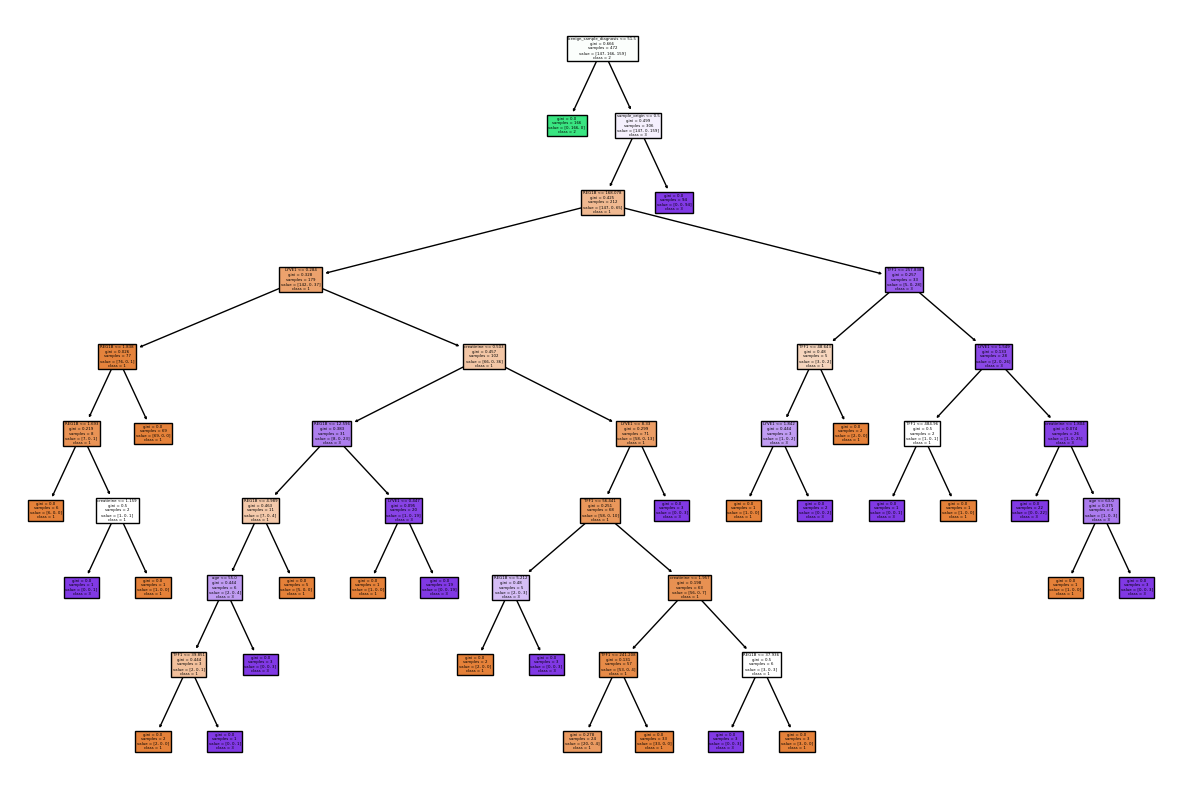

In [12]:
import matplotlib.pyplot as plt

labels = [str(x) for x in target.unique()]

plt.figure(figsize = (15, 10))
tree.plot_tree(best_tree, filled = True, feature_names = features.columns, class_names = labels)
plt.show()

## Nearest Neighbors Model

Creating a k-NN model, which attempts to classify each new point based on the classes of it's k-nearest neighbors. This model attempts to use values of k from 1-20 in order to see which is most accurate.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = { 'n_neighbors': list(range(1, 20)) }
grid = GridSearchCV(knn, param_grid, cv = cv)
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_

knn_pred_test = best_knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred_test)
lb, ub = classification_confint(knn_accuracy, len(y_test))

print("The best parameters for the model: {}".format(grid.best_params_))
print("Accuracy: {:3.2f}".format(knn_accuracy))
print("95% Confidence Interval: ({:3.2f}, {:3.2f})".format(lb, ub))

The best parameters for the model: {'n_neighbors': 6}
Accuracy: 0.61
95% Confidence Interval: (0.52, 0.70)


In this case, the grid search determined that the ideal number of neighbors is 6. Unfortunately this model is significantly less accurate than the decision tree, only 61%, and this difference is statisitically significant since the confidence interval is now 52-70%, well below that of the decision tree, whose confidence interval lower bound was 82%.

## MLP Classifier

Creating a few lists which will include all required layer/node parameters:
 - Single layer with 10-20 nodes.
 - Double layer with 10-20 in first, 10 in second.

In [14]:
one_layer = list(range(10, 21))
two_layer = [10 for _ in range(11)]
single_mlp = [(num,) for num in one_layer]
two_layer = [(num1, num2) for num1, num2 in zip(one_layer, two_layer)]

hls = single_mlp + two_layer
print(single_mlp)
print(two_layer)
print(hls)

[(10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,)]
[(10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10), (20, 10)]
[(10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10), (20, 10)]


Creating an optimal neural network for this dataset, using the previous layer dimension specifications and three different choices for activation functions.

In [15]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(random_state = 1)
param_grid = {
    'hidden_layer_sizes': hls,
    'activation': ['logistic', 'tanh', 'relu']
}
grid = GridSearchCV(nn, param_grid, cv = cv)
grid.fit(X_train, y_train)

best_nn = grid.best_estimator_

nn_pred_test = best_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, nn_pred_test)
lb, ub = classification_confint(nn_accuracy, len(y_test))

print("The best parameters for the model: {}".format(grid.best_params_))
print("Accuracy: {:3.2f}".format(nn_accuracy))
print("95% Confidence Interval: ({:3.2f}, {:3.2f})".format(lb, ub))

The best parameters for the model: {'activation': 'logistic', 'hidden_layer_sizes': (19,)}
Accuracy: 0.89
95% Confidence Interval: (0.83, 0.95)


This model does "better" than the previous best model (decision tree) but only by 1% in all three of accuracy, lower bound, and upper bound of confidence interval. One point in its favor is that it doesn't use two layers, so it's not as complex as it could've been.

## Model Metrics

Create labels for confusion matrixes, where H is a healthy patient, NCC is a non-cancerous (pancreatic) condition, and PC is pancreatic cancer.

In [16]:
labels = ['H', 'NCC', 'PC']
labels

['H', 'NCC', 'PC']

In [17]:
tree_matrix = confusion_matrix(y_true = y_test, y_pred = tree_pred_test)
knn_matrix = confusion_matrix(y_true = y_test, y_pred = knn_pred_test)
nn_matrix = confusion_matrix(y_true = y_test, y_pred = nn_pred_test)

tm_df = pd.DataFrame(tree_matrix, index = labels, columns = labels)
knnm_df = pd.DataFrame(knn_matrix, index = labels, columns = labels)
nnm_df = pd.DataFrame(nn_matrix, index = labels, columns = labels)

print("Decision Tree Confusion Matrix:\n{}".format(tm_df))
print("KNN Confusion Matrix:\n{}".format(knnm_df))
print("Neural Network Confusion Matrix:\n{}".format(nnm_df))

Decision Tree Confusion Matrix:
      H  NCC  PC
H    33    0   3
NCC   0   42   0
PC   11    0  29
KNN Confusion Matrix:
      H  NCC  PC
H    29    4   3
NCC   9   22  11
PC   10    9  21
Neural Network Confusion Matrix:
      H  NCC  PC
H    36    0   0
NCC   3   36   3
PC    7    0  33


The k-NN confusion matrix shows the same thing as the accuracy scores and confidence interval, namely that this model is sort of a mess. We can also see that with three different potential diagnoses, it's a difficult to directly evaluate false positives and negatives the way that we would with just two variables. Since what we're really looking to evaluate is pancreatic cancer, we can combine 'H' and 'NCC' and then recreate the matrix.

In [18]:
y_test_new = y_test.replace([1, 2], 0)
tree_pred_new = pd.DataFrame(tree_pred_test).replace([1, 2], 0)
nn_pred_new = pd.DataFrame(nn_pred_test).replace([1, 2], 0)
print(y_test_new.head())
print(tree_pred_new.head())
print(nn_pred_new.head())

509    3
257    0
23     0
458    3
90     0
Name: diagnosis, dtype: int64
   0
0  3
1  0
2  3
3  3
4  0
   0
0  3
1  0
2  0
3  3
4  0


In [19]:
labels = ['NC', 'PC']

tree_matrix = confusion_matrix(y_true = y_test_new, y_pred = tree_pred_new)
nn_matrix = confusion_matrix(y_true = y_test_new, y_pred = nn_pred_new)

tm_df = pd.DataFrame(tree_matrix, index = labels, columns = labels)
nnm_df = pd.DataFrame(nn_matrix, index = labels, columns = labels)

print("Decision Tree Confusion Matrix:\n{}".format(tm_df))
print("Neural Network Confusion Matrix:\n{}".format(nnm_df))

Decision Tree Confusion Matrix:
    NC  PC
NC  75   3
PC  11  29
Neural Network Confusion Matrix:
    NC  PC
NC  75   3
PC   7  33


Now with 'NC' indicating 'non-cancerous' and 'PC' indicating 'pancreatic cancer', we can see that the neural network is not just more accurate, but also does a better job avoiding false negatives. The decision tree has listed over a quarter of the cancerous cases as non-cancerous, whereas the neural network has a number closer to one in eight. Neither is a great mark, and if possible more training should be done or a better model used.  
  
We should also consider the statistical significance of the "better" model: the confidence intervals of the two models overlap almost completely, so it's worth noting that we can't actually tell the model's accuracy apart in a meaningful way.  
  
Despite the lack of statistical significance, if you must choose one of these two, the neural network is probably the way to go. It presents a lower risk of giving the OK to a patient who needs additional tests. In addition, this is not a setting where speed is critical, accuracy/avoiding false negatives is what's paramount, so there's no need to consider which is more efficient.

In [20]:
print("Decision tree false negative rate:")
print("{:3.1f}%".format(11 / (11+29) * 100))
print("Neural network false negative rate:")
print("{:3.1f}%".format(7 / (7+33) * 100))

Decision tree false negative rate:
27.5%
Neural network false negative rate:
17.5%
